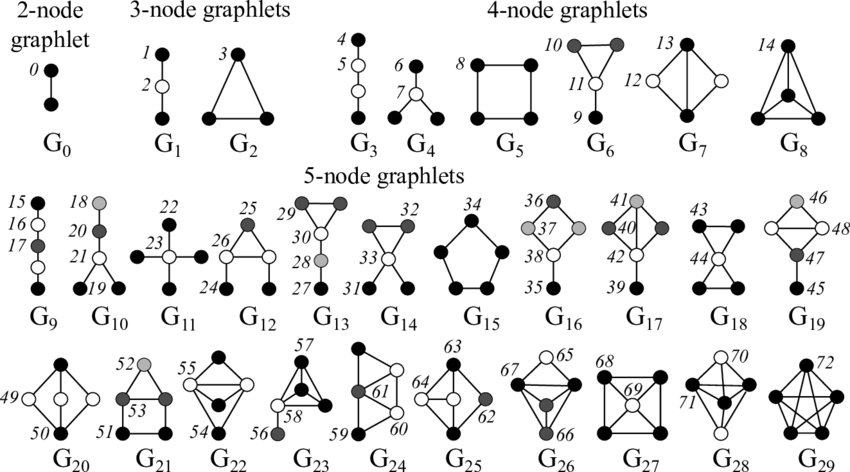

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt
import pandas as pd                                #manipulate arrays

import csv
from tqdm import tqdm
from IPython import display                        #handy for code reading

import graph_tool.clustering as gtc 
import graph_tool.generation as gtg
import graph_tool.draw as gtd                      #manipulate graphs

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering #unsupervised learning

#path to output plots, stats of this code

output = '/Users/endingalaporte/Desktop/graphlet_kernel/output/'

#import graphs and labels
    
def string_to_list(string):
    """given a string of two elements, returns each element in a list"""
    return [int(string.split(' ')[0]), int(string.split(' ')[1])]

#import 100 cities
n = 100
G_list = np.array([gt.Graph(directed = False) for i in range(n)], dtype = object)
o_f = '/Users/endingalaporte/Desktop/graphlet_kernel/input'
for i in range(n):
    open_path = o_f + "/edgelist_city"+str(i)+".txt"
    #print(open_path)
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    G_list[i].add_edge_list(elist)
    
#import 100 labels
label_path = '/Users/endingalaporte/Desktop/graphlet_kernel/input/communes_littorales.txt'
text = open(label_path, 'r')
reader = csv.reader(text, delimiter='\n')
labels = np.array([int(row[0]) for row in reader])
labels = labels[0:len(G_list)]

#import 100 names of city
names_path = '/Users/endingalaporte/Desktop/graphlet_kernel/input/communes.txt'
text = open(names_path, 'r')
reader = csv.reader(text, delimiter='\n')
names = np.array([row[0] for row in reader])
names = names[0:len(G_list)]

#import 29 graphlets
m = 29
graphlets = np.array([gt.Graph(directed = False) for i in range(m)], dtype = object)
o_f = '/Users/endingalaporte/Desktop/graphlet_kernel/src/graphlets'
for i in range(m):
    open_path = o_f + "/g"+str(i+1)+"_edgelist.txt"
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    graphlets[i].add_edge_list(elist)
    
graphlets3 = graphlets[0:2] #3-graphlets
graphlets4 = graphlets[2:8] #4-graphlets
graphlets5 = graphlets[8:29] #5-graphlets

#phi transform a graph to a size 29 vector of 345graphlet counts
def phi_345graphlet(G : gt.Graph):
    """given graph G, returns the graphlet count vector for all 29 3,4,5-graphlets"""
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    return counts345

def phi_345graphlet_normalized(G : gt.Graph):
    """
    given graph G, returns the normalized
    graphlet count vector for all connected 3,4,5-graphlets
    """
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    counts345 = counts345/counts345.sum()
    return counts345

display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/graphlets.png")

In [169]:
#fill matrix of all_phi (vector of counts not normalized)
all_phi_not_centered_not_normalized = np.zeros([n,len(graphlets)])

for i,g in tqdm(enumerate(G_list)):
    all_phi_not_centered_not_normalized[i] = phi_345graphlet(g)

100it [01:24,  1.19it/s]


In [170]:
#fill matrix of all_phi (normalized vector of counts)
all_phi_not_centered = np.zeros([n,len(graphlets)])

for i,g in tqdm(enumerate(G_list)):
    all_phi_not_centered[i] = phi_345graphlet_normalized(g)

100it [01:27,  1.14it/s]


In [171]:
#fill matrix of all_phi (center and reduce each column graphlet count accross all cities)

all_phi = all_phi_not_centered

for i in range(all_phi.shape[1]):
    if all_phi[:,i].std() != 0:
        all_phi[:,i] = (all_phi[:,i]-all_phi[:,i].mean())/all_phi[:,i].std()


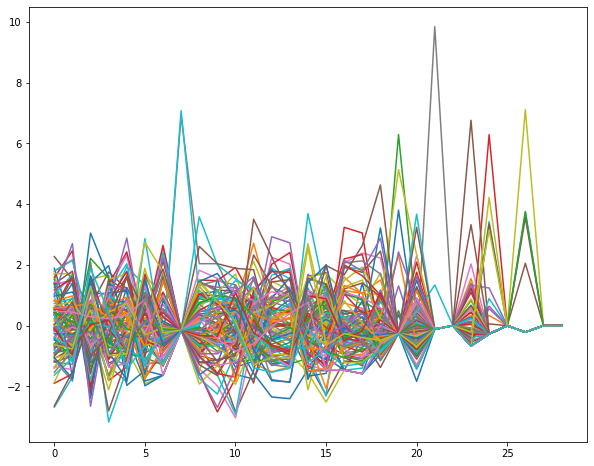

In [181]:
#visualize the phi vector of each city
plt.figure(figsize = (10,8))
for i in range(len(all_phi)):
    plt.plot(all_phi[i])
plt.savefig(output+"all_phi_normalized_centered_reduced.svg")

No handles with labels found to put in legend.


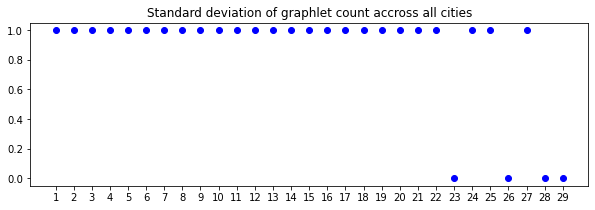

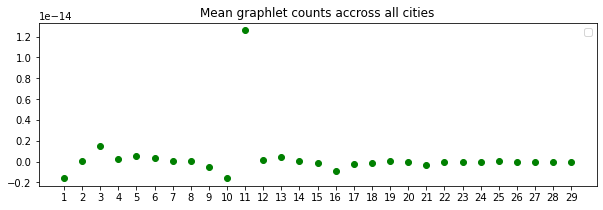

In [122]:
#standard deviation and mean of all phi vectors
std = []
mean = []
for i in range(len(all_phi[0])):
    std.append(all_phi[:,i].std())
    mean.append(all_phi[:,i].mean())

plt.figure(figsize=(10, 3))
plt.title("Standard deviation of graphlet count accross all cities")
plt.scatter(np.arange(1, len(std)+1),std, c = 'b')
plt.xticks(np.arange(1, 30, 1))

plt.figure(figsize=(10, 3))
plt.title("Mean graphlet counts accross all cities")
plt.scatter(np.arange(1, len(mean)+1),mean, c = 'g')
plt.xticks(np.arange(1, 30, 1))
plt.legend()

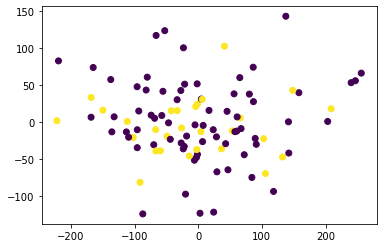

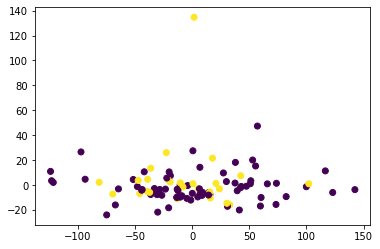

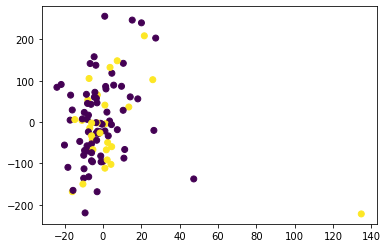

In [261]:
#kernel matrix K
K = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        K[i,j] = np.dot(all_phi[i], all_phi[j])
        
#PCA using kernel matrix K

reducer = PCA(n_components = 3)
embed = reducer.fit_transform(K)
plt.scatter(embed[:,0], embed[:,1], c = labels, marker = "o")
plt.savefig(output + '12dim_pca_345graphlet_normalized_kernel.svg')
plt.subplots()
plt.scatter(embed[:,1], embed[:,2], c = labels, marker = "o")
plt.savefig(output + '23dim_pca_345graphlet_normalized_kernel.svg')
plt.subplots()
plt.scatter(embed[:,2], embed[:,0], c = labels, marker = "o")
plt.savefig(output + '30dim_pca_345graphlet_normalized_kernel.svg')

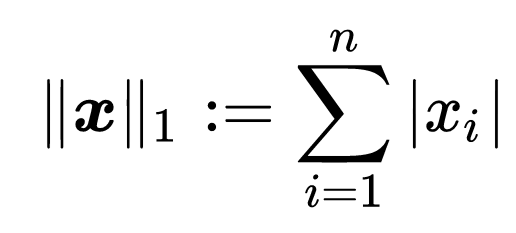

In [126]:
display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/l1_manhattan_norm.png")

/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


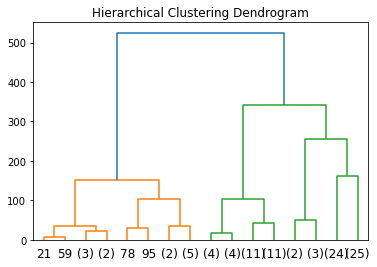

In [127]:
#distance matrix D
D = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        D[i,j] = abs((all_phi[i]-all_phi[j]).sum()) #l1 Manhattan norm

#dendogram from distance matrix D

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(D)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

In [264]:
#TSNE from distance matrix D
model = TSNE(n_components = 3)
model.fit(D)
ed = model.fit_transform(D)
plt.scatter(ed[:,0], ed[:,1], c = labels)
plt.subplots()
plt.scatter(ed[:,1], ed[:,2], c = labels)
plt.subplots()
plt.scatter(ed[:,2], ed[:,0], c = labels)

NameError: name 'D' is not defined

In [229]:
#save graphlet counts of each city to .csv

n_edges_vertices = []
for i in range(100):
    n_edges_vertices.append([len(tuple(G_list[i].edges())), len(tuple(G_list[i].vertices()))])

n_edges_vertices = np.array(n_edges_vertices)
names = np.array(names)
names = names.reshape(100,1)
labels = labels.reshape(100,1)
numpy_data = np.concatenate((names, n_edges_vertices, labels, all_phi),axis = 1)

df = pd.DataFrame(data=numpy_data
                  ,columns=["commune", "n_edges","n_vertices","is_commune_littorale","n_g1","n_g2","n_g3","n_g4","n_g5","n_g6","n_g7","n_g8","n_g9","n_g10","n_g11","n_g12","n_g13","n_g14","n_g15","n_g16","n_g17","n_g18","n_g19","n_g20","n_g21","n_g22", "n_g23", "n_g24", "n_g25", "n_g26", "n_g27", "n_g28", "n_g29"])
df.to_csv(output+"/city_stats_normalized_standardized.csv")



array([[ 1.27657709,  0.49318096,  1.06016093, ..., -0.21300942,
         0.        ,  0.        ],
       [ 0.55072094,  0.45718544, -0.7002946 , ..., -0.21300942,
         0.        ,  0.        ],
       [ 0.49068193, -0.07268462,  0.14192682, ..., -0.21300942,
         0.        ,  0.        ],
       ...,
       [ 0.34377052, -0.57876894,  1.12669407, ..., -0.21300942,
         0.        ,  0.        ],
       [-0.62367849, -0.76679795,  1.3029982 , ..., -0.21300942,
         0.        ,  0.        ],
       [ 0.35698571, -1.22147831,  1.88809792, ..., -0.21300942,
         0.        ,  0.        ]])